1. National line plot
2. Fixed regression? R2? across all years
3. Scatterplot
4. Predict next year's GDP using NTL

Sub-national
1. NUTS3 national plot
2. NUTS3 fixed regression, R2 (all regions all years)
3. Scatter all regions byyear/distribution of all regions by  year
4. Predict next years's GDP using NTL

# Analysis of Germany GDP versus harmonized nighttime lights

In [2]:
from analysis.eu_gdp_vs_ntl import *
from harmonizer.diagnostics import get_series
from harmonizer.config import OUTPUT, DMSP_CLIP, VIIRS_CLIP
import matplotlib.pyplot as plt
import seaborn as sns

## Harmonize lights
1. Set the `roipath` variable in `harmonizer/config.py` to the location of your ROI geometry file. Since Germany's shapefile is already provided as an example, you can just uncomment the corresponding path to the file in `roifiles/`
2. Execute the `main()` function in `harmonizer.main` using a trialname you choose for the `trialname` argument.
- You can do this from CLI, in root directory, e.g.: `$ python -m harmonizer.main -n germany`
3. This will take 2-3 minutes to run and when complete, you'll have the harmonized time series saved in the `output/<trialname>` sub-folder in this repo. You'll also find plots and metrics in  `results/<trialname>`

### Load NTL timeseries

For this analysis, we'll create a time series and reduce our nighttime lights radiance for our ROI (Germany) for each year we have GDP data (2000-2018) using the following reductions:
- mean (per pixel)
- median (per pixel)
- sum of all pixels


Of our ROI (Germany) for each year we have GDP data available: 2000-2018, which includes DMSP-OLS data (2000-2013) and VIIRS-DNB data (2013-2018).

For both the finalized harmonized time series as well as the un-adjusted input (for comparison).

In [3]:
gdp = load_prep()
de_gdp = gdp['DE']

<AxesSubplot:ylabel='DE'>

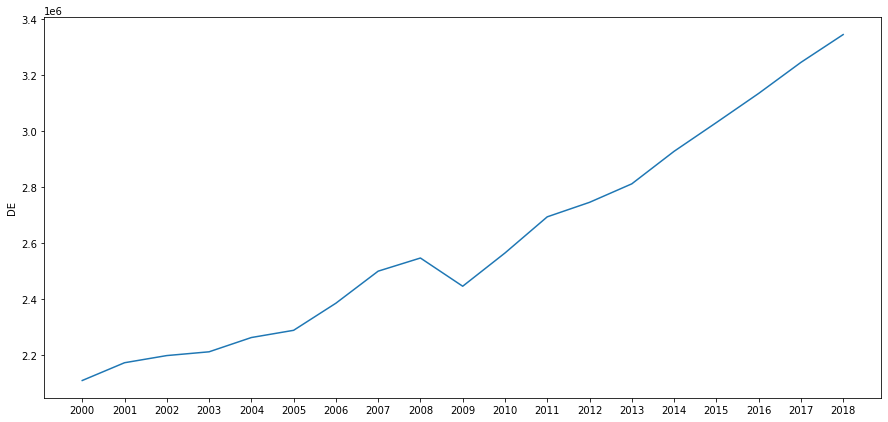

In [4]:
fig, ax = plt.subplots(1, figsize=(15,7))
sns.lineplot(data=de_gdp, ax=ax)

In [13]:
[col for col in gdp.columns if "DE" in col]

['DE',
 'DE1',
 'DE11',
 'DE111',
 'DE112',
 'DE113',
 'DE114',
 'DE115',
 'DE116',
 'DE117',
 'DE118',
 'DE119',
 'DE11A',
 'DE11B',
 'DE11C',
 'DE11D',
 'DE12',
 'DE121',
 'DE122',
 'DE123',
 'DE124',
 'DE125',
 'DE126',
 'DE127',
 'DE128',
 'DE129',
 'DE12A',
 'DE12B',
 'DE12C',
 'DE13',
 'DE131',
 'DE132',
 'DE133',
 'DE134',
 'DE135',
 'DE136',
 'DE137',
 'DE138',
 'DE139',
 'DE13A',
 'DE14',
 'DE141',
 'DE142',
 'DE143',
 'DE144',
 'DE145',
 'DE146',
 'DE147',
 'DE148',
 'DE149',
 'DE2',
 'DE21',
 'DE211',
 'DE212',
 'DE213',
 'DE214',
 'DE215',
 'DE216',
 'DE217',
 'DE218',
 'DE219',
 'DE21A',
 'DE21B',
 'DE21C',
 'DE21D',
 'DE21E',
 'DE21F',
 'DE21G',
 'DE21H',
 'DE21I',
 'DE21J',
 'DE21K',
 'DE21L',
 'DE21M',
 'DE21N',
 'DE22',
 'DE221',
 'DE222',
 'DE223',
 'DE224',
 'DE225',
 'DE226',
 'DE227',
 'DE228',
 'DE229',
 'DE22A',
 'DE22B',
 'DE22C',
 'DE23',
 'DE231',
 'DE232',
 'DE233',
 'DE234',
 'DE235',
 'DE236',
 'DE237',
 'DE238',
 'DE239',
 'DE23A',
 'DE24',
 'DE241',
 'DE2

In [8]:
set([c[:2] for c in gdp.columns])

{'AL',
 'AT',
 'BE',
 'BG',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'EU',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'MT',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR',
 'UK'}